# Telecom Churn Prediction

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

 

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

## Importing and Viewing Data

In [56]:
# Importing Libraries
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score,recall_score,precision_score,roc_auc_score,f1_score

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [57]:
# Loading Data set
telecom_df= pd.read_csv("telecom_churn_data.csv")
print(telecom_df.shape)
telecom_df.head()

(99999, 226)


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [58]:
# Missing Values check
count = 0
for x in telecom_df.columns:
    if (telecom_df[telecom_df[x].isnull()].shape[0])>0:
        print("Records with missing values in ", x)
        print(telecom_df[telecom_df[x].isnull()].shape[0])
        count +=1
print("Columns with Missing Values: ", count)

# total 166 columns with missing values

Records with missing values in  loc_og_t2o_mou
1018
Records with missing values in  std_og_t2o_mou
1018
Records with missing values in  loc_ic_t2o_mou
1018
Records with missing values in  last_date_of_month_7
601
Records with missing values in  last_date_of_month_8
1100
Records with missing values in  last_date_of_month_9
1659
Records with missing values in  onnet_mou_6
3937
Records with missing values in  onnet_mou_7
3859
Records with missing values in  onnet_mou_8
5378
Records with missing values in  onnet_mou_9
7745
Records with missing values in  offnet_mou_6
3937
Records with missing values in  offnet_mou_7
3859
Records with missing values in  offnet_mou_8
5378
Records with missing values in  offnet_mou_9
7745
Records with missing values in  roam_ic_mou_6
3937
Records with missing values in  roam_ic_mou_7
3859
Records with missing values in  roam_ic_mou_8
5378
Records with missing values in  roam_ic_mou_9
7745
Records with missing values in  roam_og_mou_6
3937
Records with missing

In [59]:
# Checking Percentage of missing values
round(100*(telecom_df.isnull().sum()/len(telecom_df.index)), 2).sort_values(ascending=False).head(100)

count_rech_2g_6             74.85
date_of_last_rech_data_6    74.85
count_rech_3g_6             74.85
av_rech_amt_data_6          74.85
max_rech_data_6             74.85
                            ...  
spl_og_mou_8                 5.38
loc_ic_t2m_mou_8             5.38
loc_og_t2f_mou_8             5.38
date_of_last_rech_9          4.76
og_others_6                  3.94
Length: 100, dtype: float64

Missing valye percentage varying from 3.94% to 74.85% (recharge related data) <br>

# Data Cleaning and Pre-Procressing

#### Deriving new features

In [60]:
# Columns with rechanrge amount or recharge data
rech_amt_col = telecom_df.columns[telecom_df.columns.str.contains('rech_amt|rech_data')]
print(rech_amt_col)

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'max_rech_amt_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6',
       'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'av_rech_amt_data_9'],
      dtype='object')


- These columns can be used to derive<br>
- Total Recharge amount<br>
- Total Data recharge<br>
- When was Last recharge done<br>
- Maximum recharge value<br>
- Average recharge value

In [61]:
# Checking Stastitical values of recharge relted variables
telecom_df.loc[:,rech_amt_col].describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.00000,25153.000000,25571.000000,26339.000000,25922.000000
mean,327.514615,322.962970,324.157122,303.345673,104.637486,104.752398,107.728207,101.943889,2.463802,2.666419,2.651999,2.441170,126.393392,126.729459,125.717301,124.94144,192.600982,200.981292,197.526489,192.734315
std,398.019701,408.114237,416.540455,404.588583,120.614894,124.523970,126.902505,125.375109,2.789128,3.031593,3.074987,2.516339,108.477235,109.765267,109.437851,111.36376,192.646318,196.791224,191.301305,188.400286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.500000,0.500000,1.000000
25%,109.000000,100.000000,90.000000,52.000000,30.000000,30.000000,30.000000,28.000000,1.000000,1.000000,1.000000,1.000000,25.000000,25.000000,25.000000,25.00000,82.000000,92.000000,87.000000,69.000000
50%,230.000000,220.000000,225.000000,200.000000,110.000000,110.000000,98.000000,61.000000,1.000000,1.000000,1.000000,2.000000,145.000000,145.000000,145.000000,145.00000,154.000000,154.000000,154.000000,164.000000
75%,437.500000,428.000000,434.500000,415.000000,120.000000,128.000000,144.000000,144.000000,3.000000,3.000000,3.000000,3.000000,177.000000,177.000000,179.000000,179.00000,252.000000,252.000000,252.000000,252.000000
max,35190.000000,40335.000000,45320.000000,37235.000000,4010.000000,4010.000000,4449.000000,3399.000000,61.000000,54.000000,60.000000,84.000000,1555.000000,1555.000000,1555.000000,1555.00000,7546.000000,4365.000000,4076.000000,4061.000000


In [62]:
# imputing missing values for recharge related data with 0, because..
# Missing value indicates 0 recharge
telecom_df['total_rech_data_6'] = telecom_df['total_rech_data_6'].replace(np.NaN,0.0)
telecom_df['total_rech_data_7'] = telecom_df['total_rech_data_7'].replace(np.NaN,0.0)
telecom_df['total_rech_data_8'] = telecom_df['total_rech_data_8'].replace(np.NaN,0.0)

telecom_df['av_rech_amt_data_6'] = telecom_df['av_rech_amt_data_6'].replace(np.NaN,0.0)
telecom_df['av_rech_amt_data_7'] = telecom_df['av_rech_amt_data_7'].replace(np.NaN,0.0)
telecom_df['av_rech_amt_data_8'] = telecom_df['av_rech_amt_data_8'].replace(np.NaN,0.0)

In [ ]:
# Creating new column for total recharge data amount total_rech_data_amt to get high value customers
telecom_df['total_rech_data_amt_6'] = telecom_df['av_rech_amt_data_6'] * telecom_df['total_rech_data_6']
telecom_df['total_rech_data_amt_7'] = telecom_df['av_rech_amt_data_7'] * telecom_df['total_rech_data_7']
telecom_df['total_rech_data_amt_8'] = telecom_df['av_rech_amt_data_8'] * telecom_df['total_rech_data_8']

In [63]:
# Creating new column of total average recharge amount for good phase months, ie, 6 and 7 
telecom_df['total_avg_rech_amnt_6_7_GPhase'] = (telecom_df['total_rech_amt_6'] + telecom_df['total_rech_data_amt_6'] \
                                               + telecom_df['total_rech_amt_7']+ telecom_df['total_rech_data_amt_7'])/2

#### Filtering out high value customers

In [64]:
# Filtering high value customers: Those who have recharged with an amount more than or equal to X, 
# where X is the 70th percentile of the average recharge amount in the first two months (the good phase).
high_value_filter = telecom_df['total_avg_rech_amnt_6_7_GPhase'].quantile(0.7)
print("70th Percentile for 6,7 month-", high_value_filter)

print("Total records ",telecom_df.shape)
telecom_df_high_val_cust = telecom_df[telecom_df['total_avg_rech_amnt_6_7_GPhase'] > high_value_filter]

print("High Value customer records", telecom_df_high_val_cust.shape)

70th Percentile for 6,7 month- 478.0
Total records  (99999, 230)
High Value customer records (29953, 230)


#### Determining Churn

In [65]:
# Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: 
# Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. 
# The attributes you need to use to tag churners are:

#total_ic_mou_9
#total_og_mou_9
#vol_2g_mb_9
#vol_3g_mb_9

high_val_cust_9 = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9','vol_3g_mb_9']
#checking for missing values and NA for these columns
round(100*(telecom_df_high_val_cust[high_val_cust_9].isnull().sum()/len(telecom_df_high_val_cust[high_val_cust_9].index)), 2).sort_values(ascending=False).head()

# Initially set all the values as 0
telecom_df_high_val_cust['churn']= 0

In [66]:
#is_churned boolean flag for customers where above identified features have 0 value
is_churned = (telecom_df_high_val_cust['total_ic_mou_9'] == 0) & \
             (telecom_df_high_val_cust['total_og_mou_9'] == 0) & \
             (telecom_df_high_val_cust['vol_2g_mb_9'] ==0) & \
             (telecom_df_high_val_cust['vol_3g_mb_9'] ==0)

is_churned

0         True
7         True
8        False
21       False
23       False
         ...  
99981    False
99984    False
99986    False
99988    False
99997    False
Length: 29953, dtype: bool

In [68]:
# settin churn as 1 for the customers having is_churned condition as True
telecom_df_high_val_cust.loc[is_churned,'churn']=1

# Checking percentage of churned custoemrs
round(100*(telecom_df_high_val_cust['churn'].sum()/len(telecom_df_high_val_cust)), 2)

8.12

In [69]:
#After tagging churners, remove all the attributes corresponding to the churn phase (attributes having ‘ _9’, in their names).
churn_month_columns =  telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('_9')]

# drop all columns corresponding to the churn phase
telecom_df_high_val_cust.drop(churn_month_columns,axis=1,inplace=True)

print(telecom_df_high_val_cust.shape)

(29953, 177)


In [70]:
# Drop Columns with > 30% of missing values except 9th Month's columns
cols = telecom_df_high_val_cust.columns
df_null_perc = telecom_df_high_val_cust.isnull().sum() * 100 / len(telecom_df_high_val_cust)
df_null_df = pd.DataFrame({'col_name': cols,
                                 'perc_null': df_null_perc})

drop_cols = df_null_df.loc[(df_null_df["col_name"].str.contains('_9')==False) & (df_null_df["perc_null"] > 30.0)]["col_name"]
print("list of columns dropped:",drop_cols)

# lets drop these columns
telecom_df_high_val_cust.drop(drop_cols, axis=1,inplace = True)
print(telecom_df_high_val_cust.shape)

list of columns dropped: date_of_last_rech_data_6    date_of_last_rech_data_6
date_of_last_rech_data_7    date_of_last_rech_data_7
date_of_last_rech_data_8    date_of_last_rech_data_8
max_rech_data_6                      max_rech_data_6
max_rech_data_7                      max_rech_data_7
max_rech_data_8                      max_rech_data_8
count_rech_2g_6                      count_rech_2g_6
count_rech_2g_7                      count_rech_2g_7
count_rech_2g_8                      count_rech_2g_8
count_rech_3g_6                      count_rech_3g_6
count_rech_3g_7                      count_rech_3g_7
count_rech_3g_8                      count_rech_3g_8
arpu_3g_6                                  arpu_3g_6
arpu_3g_7                                  arpu_3g_7
arpu_3g_8                                  arpu_3g_8
arpu_2g_6                                  arpu_2g_6
arpu_2g_7                                  arpu_2g_7
arpu_2g_8                                  arpu_2g_8
night_pck_user_6     

#### Defining some functions

In [71]:
# Function to indicate if a variable is categorical or continous
def get_variable_type(element) :
    """
     Check is columns are of Contineous or Categorical variable.
     Assumption is that if 
                 unique count < 20 then categorical 
                 unique count >= 20 and dtype = [int64 or float64] then contineous
     """
    if element==0:
        return "Not Known"
    elif element < 20 and element!=0 :
        return "Categorical"
    elif element >= 20 and element!=0 :
        return "Contineous" 
    
# Function to get meta data about variables
def get_meta_data(dataframe) :
    """
     Method to get Meta-Data about any dataframe passed 
    """
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes.astype(str), 
                    'Non_Null_Count': dataframe.count(axis = 0).astype(int), 
                    'Null_Count': dataframe.isnull().sum().astype(int), 
                    'Null_Percentage': dataframe.isnull().sum()/len(dataframe) * 100, 
                    'Unique_Values_Count': dataframe.nunique().astype(int) 
                     })
    
    metadata_matrix = predict_variable_type(metadata_matrix)
    return metadata_matrix
 
# Function to display the number of unique values
def display_columns_with_1_unique_value(dataframe):
    unique_values_count_1 = dataframe[dataframe["Unique_Values_Count"] == 1]
    drop_value_col = unique_values_count_1.index.tolist()
    lenght = len(drop_value_col)
    header("Columns with only one unique value : "+str(lenght))
    if lenght == 0 :
        print("No columns with only one unique values.")  
    else :    
        prnt("Columns with only one unique value :")
        for index,item in enumerate(drop_value_col) :
            print(index,".",item)


def predict_variable_type(metadata_matrix):
    metadata_matrix["Variable_Type"] = metadata_matrix["Unique_Values_Count"].apply(get_variable_type).astype(str)
    metadata_matrix["frequency"] = metadata_matrix["Null_Count"] - metadata_matrix["Null_Count"]
    metadata_matrix["frequency"].astype(int)
    return metadata_matrix 


def list_potential_categorical_type(dataframe,main) :
    #header("Stats for potential Categorical datatype columns")
    metadata_matrix_categorical = dataframe[dataframe["Variable_Type"] == "Categorical"]
    # TO DO *** Add check to skip below if there is no Categorical values 
    length = len(metadata_matrix_categorical)
    if length == 0 :
        print("No Categorical columns in given dataset.")  
    else :    
        metadata_matrix_categorical = metadata_matrix_categorical.filter(["Datatype","Unique_Values_Count"])
        metadata_matrix_categorical.sort_values(["Unique_Values_Count"], axis=0,ascending=False, inplace=True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check :
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({"index":name_list,"Unique_Values":values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(metadata_matrix_categorical,temp,how='inner',on='index')
        display(metadata_matrix_categorical.set_index("index")) 

def plot_data_type_pie_chat(dataframe) : 
        print("Stats for Datatype Percentage Distribution")
        dataframe_group = dataframe.groupby("Datatype").frequency.count().reset_index()
        dataframe_group.sort_values(["Datatype"], axis=0,ascending=False, inplace=True)
        trace = go.Pie(labels=dataframe_group["Datatype"].tolist(), values=dataframe_group["frequency"].tolist())
        layout = go.Layout(title="Datatype Percentage Distribution")
        fig = go.Figure(data=[trace], layout=layout)    
        py.offline.iplot(fig)
    
def get_potential_categorical_type(dataframe,main,unique_count) :
    metadata_matrix_categorical = dataframe[dataframe["Variable_Type"] == "Categorical"]
    metadata_matrix_categorical = dataframe[dataframe["Unique_Values_Count"] == unique_count]
    length = len(metadata_matrix_categorical)
    if length == 0 :
        print("No Categorical columns in given dataset.")
    else :
        metadata_matrix_categorical = metadata_matrix_categorical.filter(["Datatype","Unique_Values_Count"])
        metadata_matrix_categorical.sort_values(["Unique_Values_Count"], axis=0,ascending=False, inplace=True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check :
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({"index":name_list,"Unique_Values":values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(metadata_matrix_categorical,temp,how='inner',on='index')
        display(metadata_matrix_categorical.set_index("index")) 

In [72]:
# Checking if variable is categorical or continous by checking the number of unique values
list_potential_categorical_type(get_meta_data(telecom_df_high_val_cust),telecom_df_high_val_cust)

,Datatype,Unique_Values_Count,Unique_Values
index,,,
monthly_3g_7,int64,15,"[1, 0, 2, 5, 3, 8, 4, 7, 6, 9, 11, 12, 14, 10,..."
monthly_3g_8,int64,12,"[1, 0, 2, 7, 3, 4, 6, 5, 8, 10, 9, 16]"
monthly_3g_6,int64,12,"[1, 0, 4, 2, 3, 5, 7, 6, 9, 8, 11, 14]"
monthly_2g_8,int64,6,"[0, 1, 2, 5, 3, 4]"
monthly_2g_7,int64,6,"[0, 1, 2, 5, 4, 3]"
monthly_2g_6,int64,5,"[0, 2, 1, 3, 4]"
churn,int64,2,"[1, 0]"
loc_og_t2o_mou,float64,1,"[0.0, nan]"
std_ic_t2o_mou_8,float64,1,"[0.0, nan]"


In [73]:
# Dropping columns with unique values
drop_col_with_unique_col =['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 
                           'last_date_of_month_7', 'last_date_of_month_8','std_og_t2c_mou_6', 'std_og_t2c_mou_7', 
                          'std_og_t2c_mou_8',  'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']

telecom_df_high_val_cust.drop(drop_col_with_unique_col,axis=1,inplace=True)

print(telecom_df_high_val_cust.shape)


(29953, 140)


In [76]:
# exploring date columns
date_col = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('date')]
date_col

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], dtype='object')

In [77]:
# date_col = ['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_data_6',
#            'date_of_last_rech_data_7','date_of_last_rech_data_8']

date_col = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']
telecom_df_high_val_cust[date_col].head(5)

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
0,6/21/2014,7/16/2014,8/8/2014
7,6/27/2014,7/25/2014,8/26/2014
8,6/25/2014,7/31/2014,8/30/2014
21,6/30/2014,7/31/2014,8/31/2014
23,6/18/2014,7/7/2014,8/24/2014


In [78]:
# Converting date related columns to date type
for col in date_col:
    telecom_df_high_val_cust[col] = pd.to_datetime(telecom_df_high_val_cust[col])
telecom_df_high_val_cust[date_col].head(5)

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
0,2014-06-21,2014-07-16,2014-08-08
7,2014-06-27,2014-07-25,2014-08-26
8,2014-06-25,2014-07-31,2014-08-30
21,2014-06-30,2014-07-31,2014-08-31
23,2014-06-18,2014-07-07,2014-08-24


In [79]:
# create box plot for  6th, 7th and 8th month
def plot_box_chart(attribute):
    plt.figure(figsize=(20,16))
    df = telecom_df_high_val_cust
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=attribute+"_6",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=attribute+"_7",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=attribute+"_8",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.show()

## Exploratory analysis

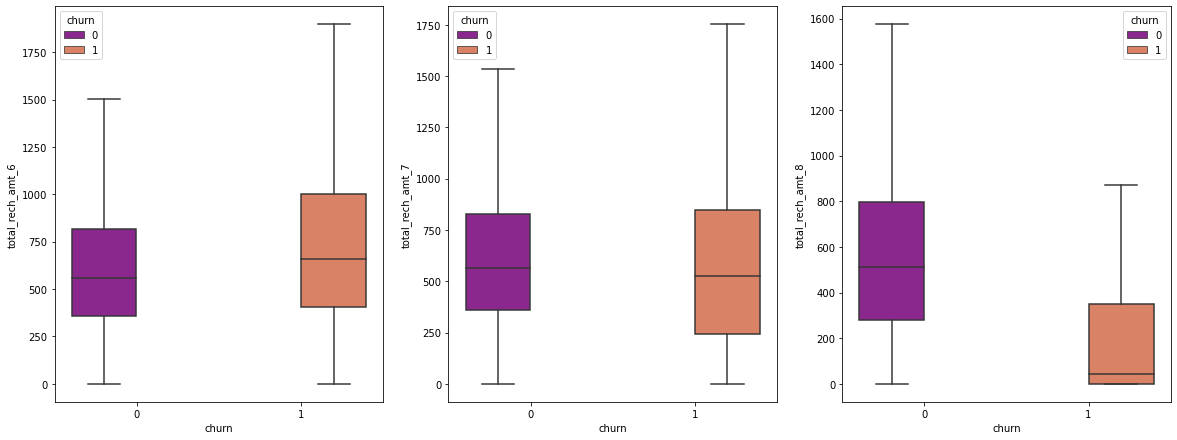

In [80]:
# Ploting for total recharge amount:
plot_box_chart('total_rech_amt')
#We can see a drop in the total recharge amount for churned customers in the 8th Month (Action Phase).

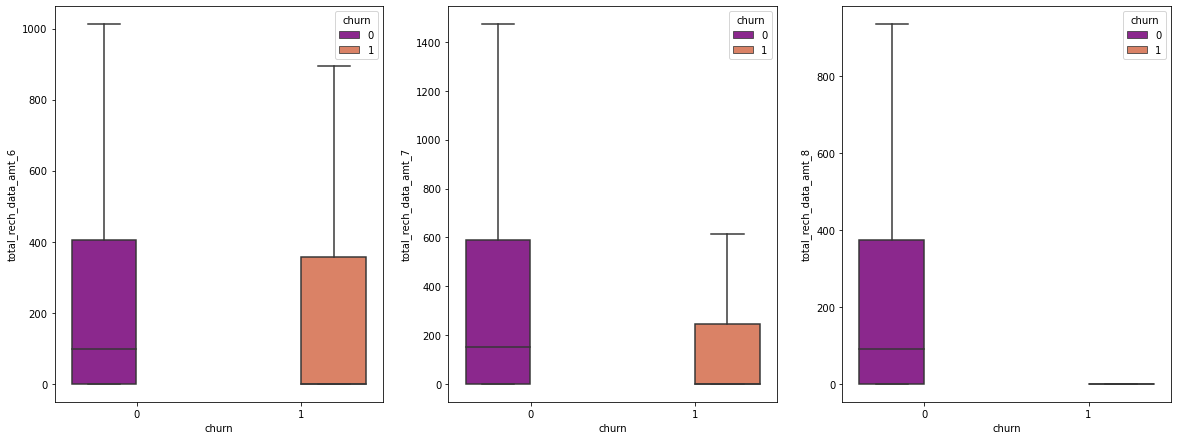

In [81]:
# Ploting for total recharge amount for data:
plot_box_chart('total_rech_data_amt')
#We can see that there is a huge drop in total recharge amount for data in the 8th month (action phase) for churned customers.

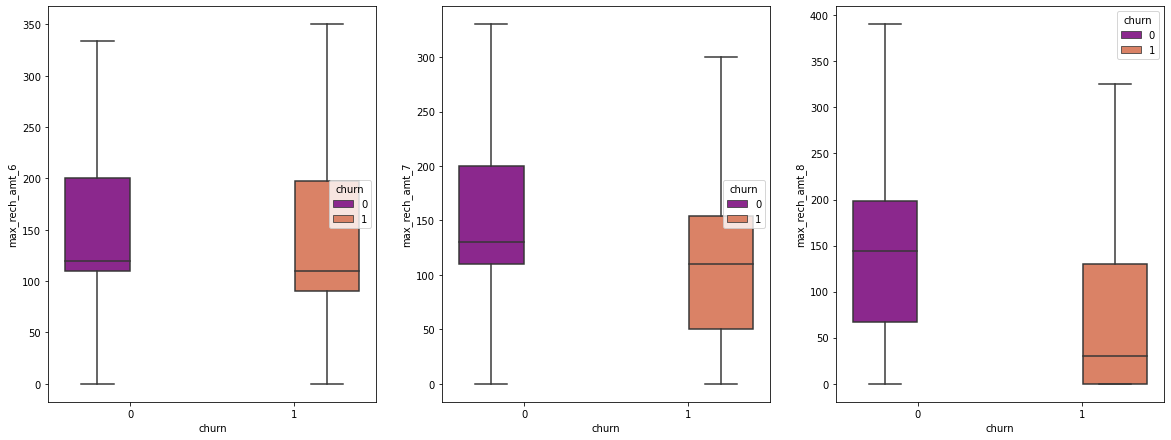

In [82]:
# Ploting for maximum recharge amount for data:
plot_box_chart('max_rech_amt')
#We can see that there is a huge drop in maximum recharge amount for data in the 8th month (action phase) for churned customers.

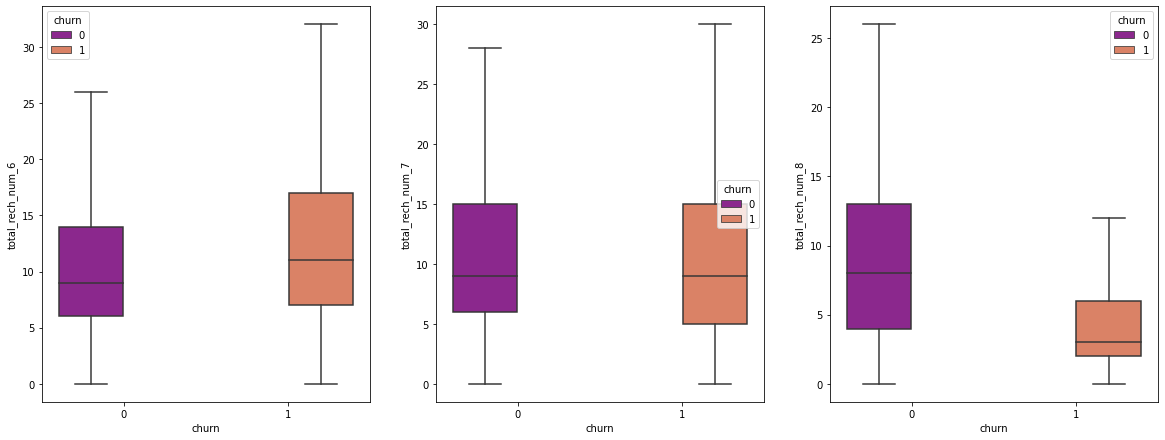

In [84]:
# Ploting for Total recharge for Number:
plot_box_chart('total_rech_num')
#We can see that there is a huge drop in total recharge number also in the 8th month (action phase) for churned customers.

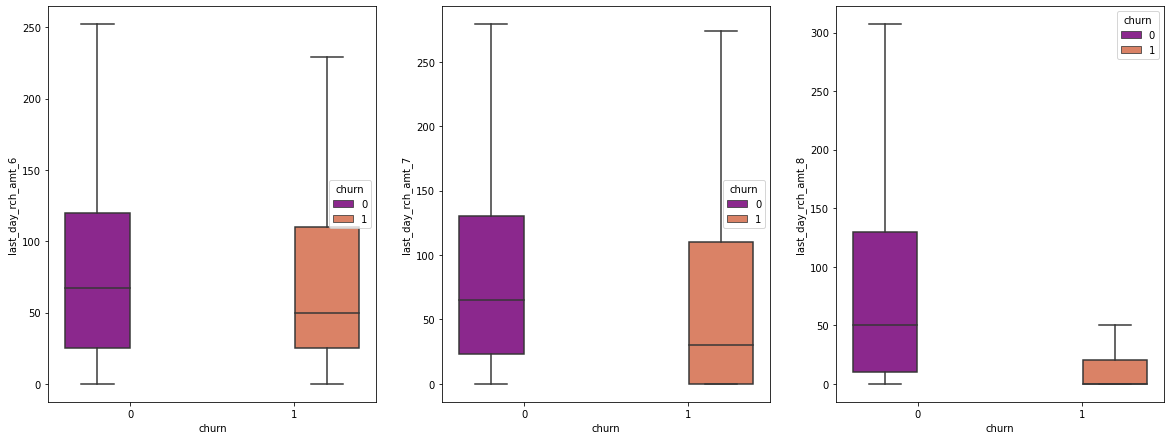

In [86]:
# Ploting for last day recharge amount:
plot_box_chart('last_day_rch_amt')
#  We are getting a huge drop in 8th month recharge amount for churned customers.

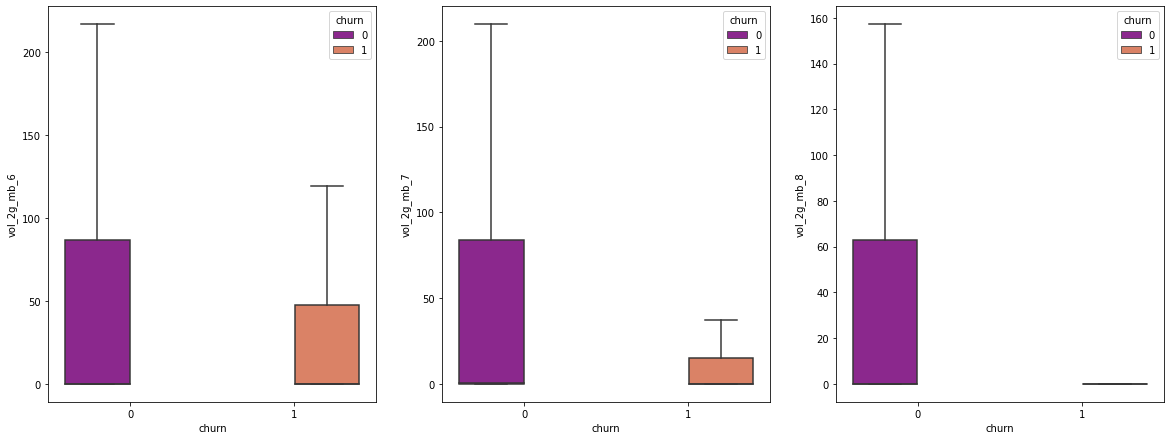

In [87]:
# Ploting for volume of 2G and 3G usage columns:
plot_box_chart('vol_2g_mb')
# Huge drop in the 2g data for churned customers in 8th month, it has also decreased consistently over the months.

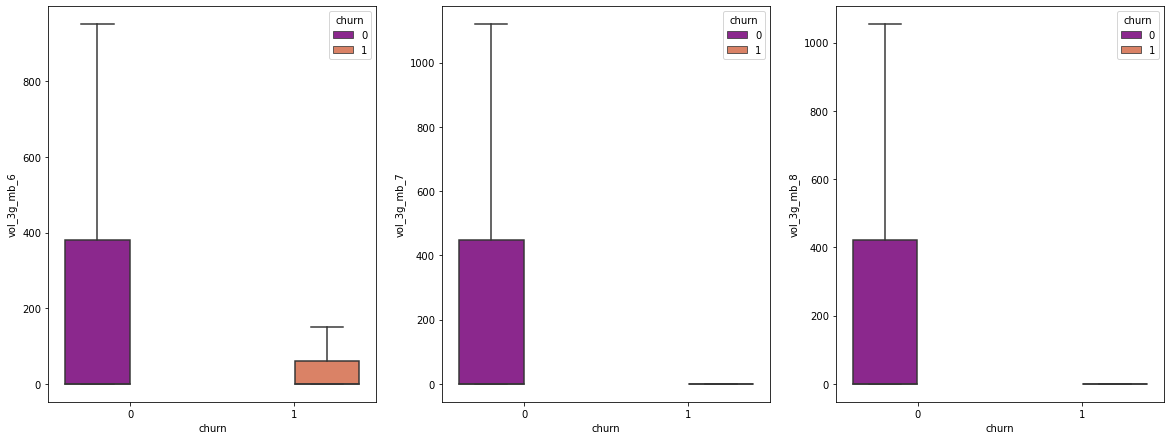

In [88]:
plot_box_chart('vol_3g_mb')

Huge drop in the 3g data for churned customers in 8th month, it has also decreased consistently over the months. <br>

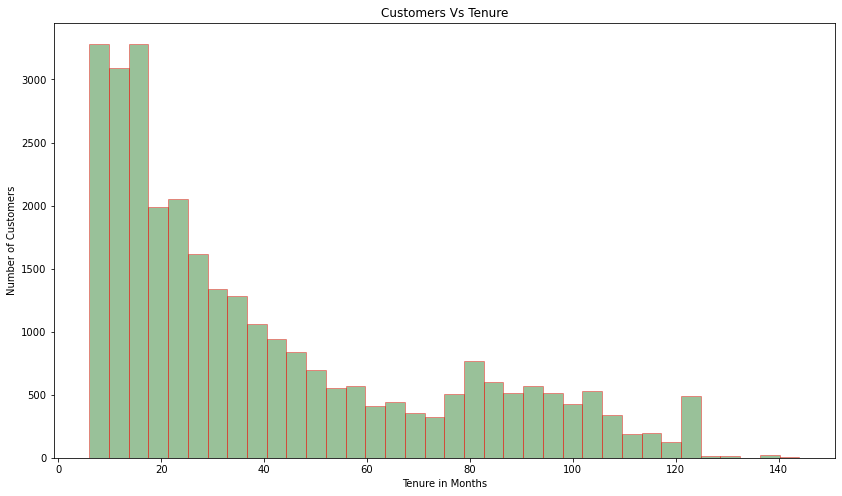

In [89]:
# plotting the distribution of customers as per the number of months they have been using the service
plt.figure(figsize=(14,8))
# aon --> Age on network - number of days the customer is using the operator T network
telecom_df_high_val_cust['tenure'] = telecom_df_high_val_cust['aon']/30
telecom_df_high_val_cust['tenure'].head()
ax = sns.distplot(telecom_df_high_val_cust['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkgreen', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Tenure in Months')
ax.set_title('Customers Vs Tenure')
plt.show()

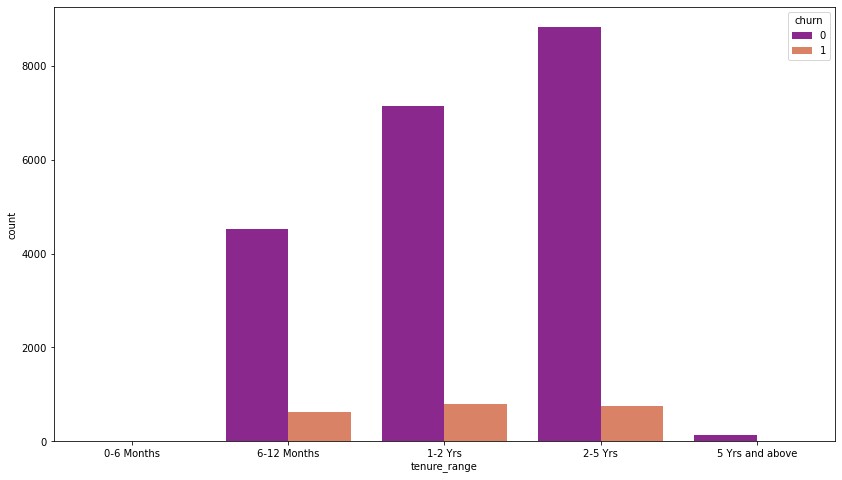

In [90]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
telecom_df_high_val_cust['tenure_range'] = pd.cut(telecom_df_high_val_cust['tenure'], tn_range, labels=tn_label)

plt.figure(figsize=(14,8))
sns.countplot(x = 'tenure_range', hue = 'churn',data = telecom_df_high_val_cust,palette=("plasma"))
plt.show()


In [101]:
# Dropping 'tenure_range' column
telecom_df_high_val_cust.drop(["tenure_range"],axis=1,inplace=True)

In [102]:
# Checking dataset again for null values
(telecom_df_high_val_cust.isnull().sum() * 100 / len(telecom_df_high_val_cust)).sort_values(ascending = False).head(40)

og_others_8            3.912797
std_ic_t2m_mou_8       3.912797
std_og_t2m_mou_8       3.912797
isd_og_mou_8           3.912797
ic_others_8            3.912797
std_og_t2t_mou_8       3.912797
isd_ic_mou_8           3.912797
loc_og_mou_8           3.912797
spl_ic_mou_8           3.912797
loc_og_t2c_mou_8       3.912797
loc_og_t2f_mou_8       3.912797
spl_og_mou_8           3.912797
std_ic_mou_8           3.912797
loc_og_t2m_mou_8       3.912797
std_og_t2f_mou_8       3.912797
loc_og_t2t_mou_8       3.912797
std_ic_t2f_mou_8       3.912797
roam_og_mou_8          3.912797
loc_ic_mou_8           3.912797
loc_ic_t2t_mou_8       3.912797
loc_ic_t2m_mou_8       3.912797
onnet_mou_8            3.912797
offnet_mou_8           3.912797
loc_ic_t2f_mou_8       3.912797
std_og_mou_8           3.912797
std_ic_t2t_mou_8       3.912797
roam_ic_mou_8          3.912797
date_of_last_rech_8    1.943044
ic_others_6            1.809502
isd_og_mou_6           1.809502
loc_ic_t2t_mou_6       1.809502
og_other

In [103]:
# Minutes of usage calls
mou_cols = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('mou')]
# replaceing null values by 0 for minutes of usage variables
telecom_df_high_val_cust.loc[:,mou_cols] = telecom_df_high_val_cust.loc[:,mou_cols].replace(np.NaN,0)

In [105]:
# Checking dataset again for null values
(telecom_df_high_val_cust.isnull().sum() * 100 / len(telecom_df_high_val_cust)).sort_values(ascending = False).head(10)

ic_others_8            3.912797
og_others_8            3.912797
date_of_last_rech_8    1.943044
og_others_6            1.809502
ic_others_6            1.809502
ic_others_7            1.789470
og_others_7            1.789470
date_of_last_rech_7    0.327179
date_of_last_rech_6    0.243715
std_og_t2f_mou_7       0.000000
dtype: float64

In [106]:
# NAN's to 0 for numerical cols
numberic_col = ['og_others_8', 'ic_others_8', 'og_others_6','ic_others_6', 'og_others_7', 'ic_others_7']
for i in numberic_col:
    telecom_df_high_val_cust.loc[telecom_df_high_val_cust[i].isnull(),i]=0

In [107]:
# Checking dataset again for null values
(telecom_df_high_val_cust.isnull().sum() * 100 / len(telecom_df_high_val_cust)).sort_values(ascending = False).head(5)

date_of_last_rech_8    1.943044
date_of_last_rech_7    0.327179
date_of_last_rech_6    0.243715
tenure                 0.000000
isd_og_mou_6           0.000000
dtype: float64

In [110]:
# dropping ate columns
telecom_df_high_val_cust.drop(["date_of_last_rech_8","date_of_last_rech_7","date_of_last_rech_6"],axis=1,inplace=True)
telecom_df_high_val_cust.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,total_avg_rech_amnt_6_7_GPhase,churn,tenure
0,7000842753,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,...,30.40,0.00,101.20,3.58,252.0,252.0,252.0,559.0,1,32.266667
7,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,...,57.74,19.38,18.74,0.00,0.0,0.0,0.0,1185.0,1,26.733333
8,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,...,21.03,910.65,122.16,0.00,0.0,354.0,207.0,696.0,0,10.500000
21,7002124215,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,640.0,0,24.000000
23,7000887461,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,...,40.45,51.86,0.00,0.00,0.0,712.0,540.0,583.0,0,20.133333


In [137]:
def split_data(df):
    Y = df["churn"]
    X = df.drop(["churn","mobile_number"],axis=1)
    return X,Y
    
def scale_data(X):
    scaler = StandardScaler()
    X_col = X.columns
    X_scaled = scaler.fit_transform(X)
    X_scale_final = pd.DataFrame(X_scaled, columns=X_col)    
    return X_scale_final

def resampling_data(X,Y,feature_number,train_size=0.7,test_size=0.3) :
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, train_size=train_size, random_state=1)

    print("Shape of train datatset before : "+str(x_train.shape))
    print("Percenatge of Churned customer data : "+str(round(100*Y.sum()/len(Y),2)))
    print("Applying SMOTE to normalize imbalance ....")

    #Initializing SMOTE: Synthetic Minority Over-sampling Technique
    # using this as data is skewed 
    smote = SMOTE(random_state=42, sampling_strategy=0.6)
    x_tr,y_tr = smote.fit_sample(x_train,y_train)
    print("Shape of train datatset after SMOTE : "+str(x_tr.shape))

    # Applying PCA : Pricnipal Component Analysis
    pca = IncrementalPCA(n_components=feature_number)    
    x_tr_pca = pca.fit_transform(x_tr)
    x_test_pca = pca.transform(x_test)
    print("Shape of train datatset after PCA : "+str(x_tr_pca.shape))

    return x_tr_pca,x_test_pca,y_tr,y_test


## Principal Component Analysis

In [124]:
# Splitting data to X and y
X,Y=split_data(telecom_df_high_val_cust)
x_scaled = scale_data(X)

# importing PCA liberary
from sklearn.decomposition import PCA
pca = PCA(random_state=100)

# Fitting PCA
pca.fit(x_scaled)

# Viewing PCA components
pca.components_

array([[ 1.52841189e-01,  1.62560883e-01,  1.57881681e-01, ...,
        -5.63744426e-02, -1.10982795e-02,  3.59727634e-02],
       [ 2.25021409e-02,  1.99203699e-02,  3.67028019e-02, ...,
         8.29491044e-02,  1.06208844e-01,  7.87184470e-02],
       [ 1.36915628e-01,  1.65276529e-01,  1.61822009e-01, ...,
         1.67317241e-01,  2.49468852e-01, -6.08557857e-02],
       ...,
       [ 0.00000000e+00,  2.12550560e-18,  3.63588417e-16, ...,
         2.56989869e-17,  1.53476225e-01, -4.57952303e-01],
       [-0.00000000e+00, -9.16279842e-17,  1.59887827e-16, ...,
        -9.62705716e-17, -1.81820531e-01,  4.84638250e-01],
       [ 0.00000000e+00, -1.16128294e-16,  1.84033499e-18, ...,
         1.35032895e-16,  5.12048983e-01,  8.58214864e-02]])

In [125]:
# Checking explained variance ratio
pca.explained_variance_ratio_

array([1.07473090e-01, 8.35208502e-02, 6.53049552e-02, 4.89097093e-02,
       4.26880971e-02, 3.40968040e-02, 2.94321619e-02, 2.66071671e-02,
       2.47949350e-02, 2.31636748e-02, 2.20883680e-02, 2.06815539e-02,
       2.03227322e-02, 1.96854555e-02, 1.89873790e-02, 1.76636689e-02,
       1.54868404e-02, 1.44075133e-02, 1.42307356e-02, 1.38426882e-02,
       1.30245380e-02, 1.25416452e-02, 1.22208636e-02, 1.16528771e-02,
       1.14007425e-02, 1.02892806e-02, 1.00269784e-02, 9.78944274e-03,
       9.15603618e-03, 8.55375965e-03, 8.13285024e-03, 7.82463146e-03,
       7.66702405e-03, 7.34315078e-03, 6.90992235e-03, 6.90052296e-03,
       6.81454095e-03, 6.58698104e-03, 6.47483659e-03, 6.13923192e-03,
       5.92908327e-03, 5.74224206e-03, 5.64901881e-03, 5.17342566e-03,
       5.07252850e-03, 4.77294411e-03, 4.68750721e-03, 4.47099143e-03,
       4.37030353e-03, 4.30992641e-03, 3.81512421e-03, 3.69936432e-03,
       3.65246667e-03, 3.62127762e-03, 3.53108922e-03, 3.40375068e-03,
      

<BarContainer object of 136 artists>

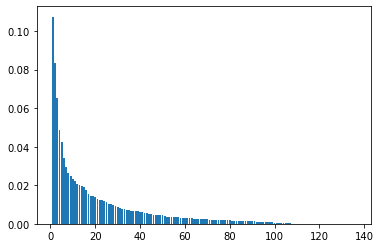

In [126]:
# Plotting explained ratio
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)

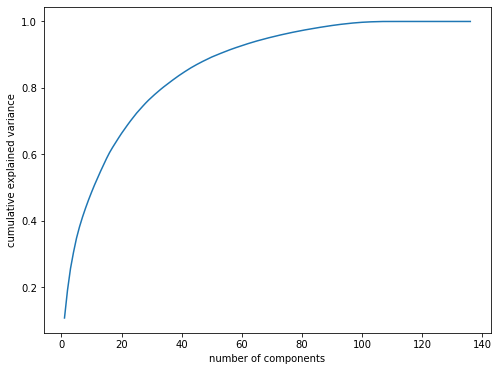

In [127]:
# Making the scree plot
var_cumu = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize = (8,6))
plt.plot(range(1,len(var_cumu)+1), var_cumu)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [174]:
col = list(x_scaled.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
print(df_pca.shape)
df_pca.head(10)

(136, 4)


,PC1,PC2,PC3,Feature
0,0.152841,0.022502,0.136916,arpu_6
1,0.162561,0.019920,0.165277,arpu_7
2,0.157882,0.036703,0.161822,arpu_8
3,0.116525,-0.103548,0.047583,onnet_mou_6
4,0.126574,-0.112576,0.064027,onnet_mou_7
5,0.126572,-0.096591,0.070599,onnet_mou_8
6,0.157462,-0.053168,0.042056,offnet_mou_6
7,0.166421,-0.063021,0.060517,offnet_mou_7
8,0.161692,-0.042832,0.066757,offnet_mou_8
9,0.021422,-0.003140,0.019483,roam_ic_mou_6


#### _Analysis: Looks like 80 components are enough to describe 95% of the variance in the dataset_
#### _We'll choose 80 components for our modeling_ <br><br>

In [206]:
x_train, x_test, y_train, y_test = resampling_data(x_scaled,Y,80)

Shape of train datatset before : (20967, 136)
Percenatge of Churned customer data : 8.12
Applying SMOTE to normalize imbalance ....
Shape of train datatset after SMOTE : (30822, 136)
Shape of train datatset after PCA : (30822, 80)


# Model Building <br><br>

## Logistic Regression

In [207]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Defining Logistic Regression object
lr = LogisticRegression(class_weight='balanced')
model = lr.fit(x_train,y_train)

#Making prediction on the test data
pred_probs_test = model.predict_proba(x_test)[:,1]
print("Linear Regression Accurancy : "+"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test)))

Linear Regression Accurancy : 0.89


In [ ]:
# Making predictions
y_pred = rfc.predict(x_test)

#### Model evalulation

In [208]:
# Confusion matrix
cp = confusion_matrix(y_test,y_pred)
cp

array([[7687,  569],
       [ 297,  433]], dtype=int64)

In [209]:
# Checking different metrics to evaluate models
accuracy = round(accuracy_score(y_test,y_pred),2)
recall = round(recall_score(y_test,y_pred),2)
precision = round(precision_score(y_test,y_pred),2)
auc = round(roc_auc_score(y_test,y_pred),2)
f1 = round(f1_score(y_test,y_pred),2)

data = [[accuracy,recall,precision,auc,f1]] 
df = pd.DataFrame(data, columns = ['Accuracy','Precision','Recall','AUC','F1'])
df.head()

,Accuracy,Precision,Recall,AUC,F1
0,0.9,0.59,0.43,0.76,0.5


Feature: 0, Score: -0.24688
Feature: 1, Score: 0.66305
Feature: 2, Score: -0.03976
Feature: 3, Score: 0.38992
Feature: 4, Score: -0.06292
Feature: 5, Score: -0.06136
Feature: 6, Score: 0.04804
Feature: 7, Score: 0.58927
Feature: 8, Score: 0.40578
Feature: 9, Score: 0.13731
Feature: 10, Score: -0.18567
Feature: 11, Score: 0.16496
Feature: 12, Score: -0.13849
Feature: 13, Score: 0.02332
Feature: 14, Score: -0.23850
Feature: 15, Score: 0.17299
Feature: 16, Score: 0.30032
Feature: 17, Score: 0.38249
Feature: 18, Score: -0.07461
Feature: 19, Score: 0.35505
Feature: 20, Score: 0.11270
Feature: 21, Score: -0.60468
Feature: 22, Score: -0.14235
Feature: 23, Score: 0.00666
Feature: 24, Score: 0.17522
Feature: 25, Score: -0.00618
Feature: 26, Score: 0.04495
Feature: 27, Score: -0.12543
Feature: 28, Score: 0.46268
Feature: 29, Score: 0.15138
Feature: 30, Score: -0.27767
Feature: 31, Score: -0.45056
Feature: 32, Score: -0.28067
Feature: 33, Score: -0.08985
Feature: 34, Score: -0.05089
Feature: 35, 

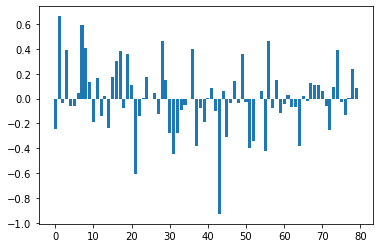

In [165]:
# get feature importance
importance = model.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Random Forest 

In [140]:
# Defining Random forest object
rfc = RandomForestClassifier()

# Fitting data
rfc.fit(x_train,y_train)

RandomForestClassifier()

In [ ]:
# Making predictions
y_pred = rfc.predict(x_test)

In [142]:
# Confusion Matrix
cp = confusion_matrix(y_test,y_pred)
cp

array([[7909,  347],
       [ 406,  324]], dtype=int64)

In [145]:
# Metrix to check model accurazy
accuracy = round(accuracy_score(y_test,y_pred),2)
recall = round(recall_score(y_test,y_pred),2)
precision = round(precision_score(y_test,y_pred),2)
auc = round(roc_auc_score(y_test,y_pred),2)
f1 = round(f1_score(y_test,y_pred),2)

data = [[accuracy,recall,precision,auc,f1]] 
df = pd.DataFrame(data, columns = ['Accuracy','Precision','Recall','AUC','F1'])
df.head()

,Accuracy,Precision,Recall,AUC,F1
0,0.92,0.44,0.48,0.7,0.46


### Hyper Parameter Tuning on Random Forest

In [154]:
# Defining function for grid search cv
def tune_hyperparameter(parameters,x_train,y_train,n_folds = 3,max_depth=0):
    
    if(max_depth==0):
        rf = RandomForestClassifier()
    else :
        rf = RandomForestClassifier(max_depth=max_depth)
        
    rf = GridSearchCV(rf, parameters, cv=n_folds,n_jobs = -1, scoring="accuracy",return_train_score=True)
    rf.fit(x_train, y_train)
    scores = rf.cv_results_

    for key in parameters.keys():
        hyperparameters = key
        break

    # plotting accuracies for parameters
    plt.figure(figsize=(16,5))
    plt.plot(scores["param_"+hyperparameters], scores["mean_train_score"], label="training accuracy")
    plt.plot(scores["param_"+hyperparameters], scores["mean_test_score"], label="test accuracy")
    plt.xlabel(hyperparameters)
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

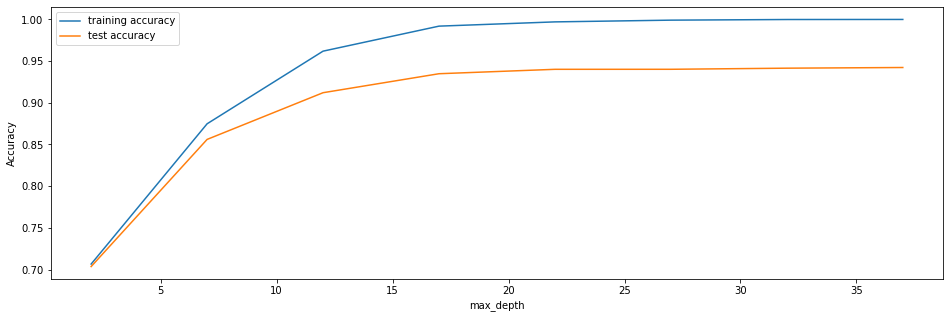

In [155]:
# Tuning max_depth
parameters = {'max_depth': range(2, 40, 5)}
tune_hyperparameter(parameters,x_train,y_train)

#12 and 18 value have peek convergens and can be used for grid veiw search.

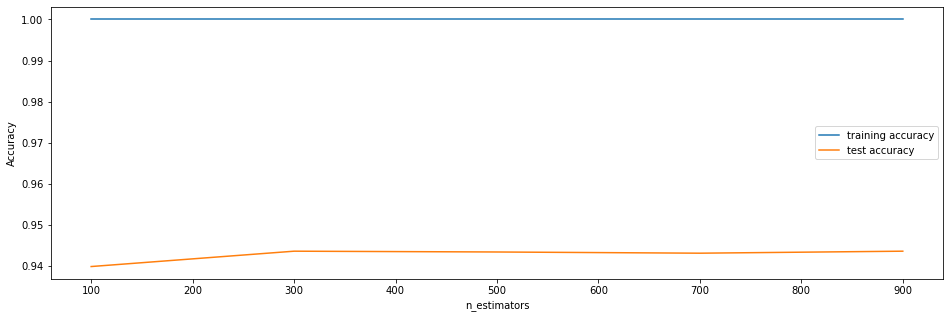

In [157]:
# Tuning n_estimators
parameters = {'n_estimators': range(100, 1000, 200)}
tune_hyperparameter(parameters,x_train,y_train)
# Training accuracy is flat, test accuracy stablizes after 300.

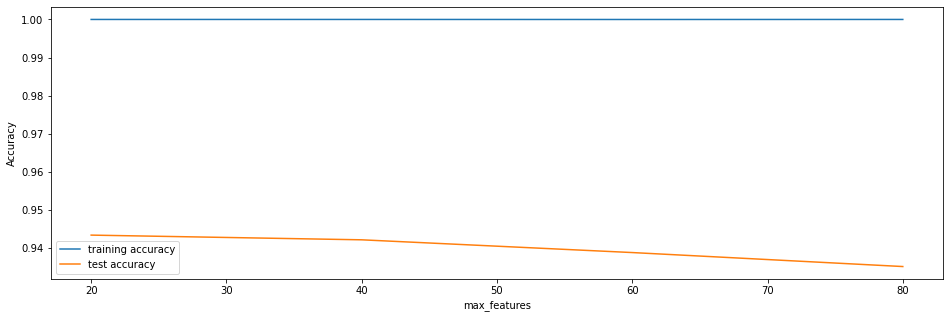

In [158]:
#  Tuning max_features
parameters = {'max_features': [20,40,60,80]}
tune_hyperparameter(parameters,x_train,y_train,4)
# For training the feature seems to be stable... for test selecting 40.

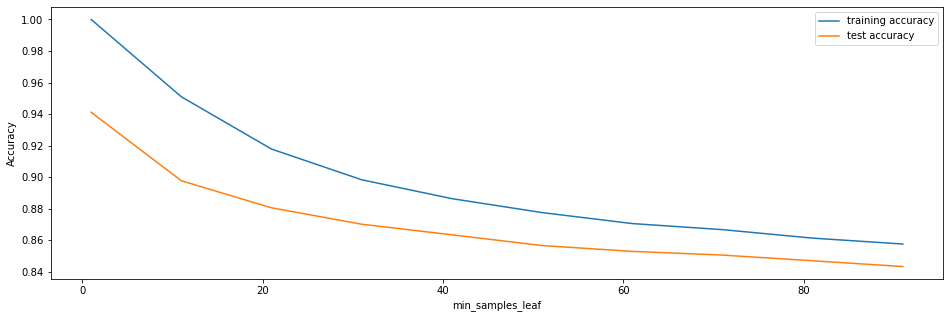

In [159]:
# Tuning min_samples_leaf
parameters = {'min_samples_leaf': range(1, 100, 10)}
tune_hyperparameter(parameters,x_train,y_train)
# 10 to 20 seems good value post 20 the model seems to overfit

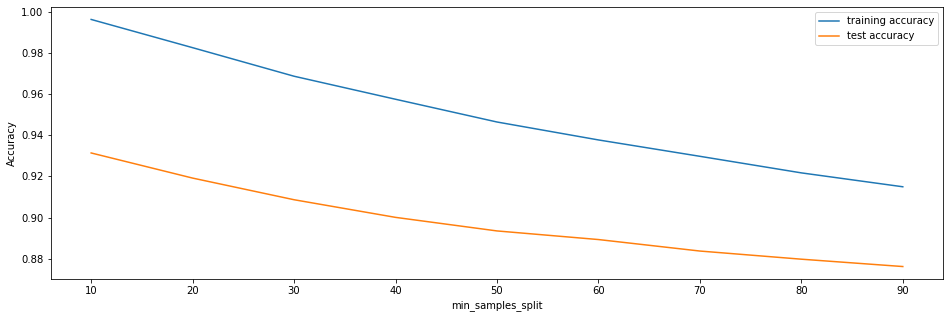

In [160]:
# Tuning min_samples_split
parameters = {'min_samples_split': range(10, 100, 10)}
tune_hyperparameter(parameters,x_train,y_train)
#Range 10 to 40 seems to be optimal value, taking 20

#### Creating new model with optimal values

In [162]:
rfc = RandomForestClassifier(max_depth=18,
                             max_features=40,
                             min_samples_leaf=10,
                             min_samples_split=20,
                             n_estimators=300,
                             n_jobs = -1)
rfc.fit(x_train,y_train)

RandomForestClassifier(max_depth=18, max_features=40, min_samples_leaf=10,
                       min_samples_split=20, n_estimators=300, n_jobs=-1)

In [ ]:
# Making predictions
y_pred = rfc.predict(x_test)

In [166]:
# confusion_matrix
cp = confusion_matrix(y_test,y_pred)
cp

array([[7687,  569],
       [ 297,  433]], dtype=int64)

In [167]:
# Checking metrics to evaluate model
accuracy = round(accuracy_score(y_test,y_pred),2)
recall = round(recall_score(y_test,y_pred),2)
precision = round(precision_score(y_test,y_pred),2)
auc = round(roc_auc_score(y_test,y_pred),2)
f1 = round(f1_score(y_test,y_pred),2)

data = [[accuracy,recall,precision,auc,f1]] 
df = pd.DataFrame(data, columns = ['Accuracy','Precision','Recall','AUC','F1'])
df.head()

,Accuracy,Precision,Recall,AUC,F1
0,0.9,0.59,0.43,0.76,0.5


Feature: 0, Score: 0.02674
Feature: 1, Score: 0.21016
Feature: 2, Score: 0.00716
Feature: 3, Score: 0.03159
Feature: 4, Score: 0.00617
Feature: 5, Score: 0.00719
Feature: 6, Score: 0.00534
Feature: 7, Score: 0.14643
Feature: 8, Score: 0.06439
Feature: 9, Score: 0.00615
Feature: 10, Score: 0.00689
Feature: 11, Score: 0.00539
Feature: 12, Score: 0.00547
Feature: 13, Score: 0.00705
Feature: 14, Score: 0.00673
Feature: 15, Score: 0.00950
Feature: 16, Score: 0.01185
Feature: 17, Score: 0.04545
Feature: 18, Score: 0.00588
Feature: 19, Score: 0.02164
Feature: 20, Score: 0.00403
Feature: 21, Score: 0.03643
Feature: 22, Score: 0.00618
Feature: 23, Score: 0.00668
Feature: 24, Score: 0.00614
Feature: 25, Score: 0.00435
Feature: 26, Score: 0.00496
Feature: 27, Score: 0.00893
Feature: 28, Score: 0.00904
Feature: 29, Score: 0.00510
Feature: 30, Score: 0.00506
Feature: 31, Score: 0.02199
Feature: 32, Score: 0.01311
Feature: 33, Score: 0.00518
Feature: 34, Score: 0.00532
Feature: 35, Score: 0.00627
Fe

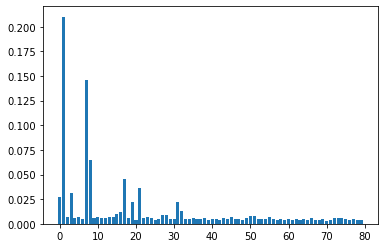

In [164]:
# get importance
importance = rfc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### XG Boost

In [182]:
x_train, x_test, y_train, y_test = resampling_data(x_scaled,Y,80)

Shape of train datatset before : (20967, 136)
Percenatge of Churned customer data : 8.12
Applying SMOTE to normalize imbalance ....
Shape of train datatset after SMOTE : (30822, 136)
Shape of train datatset after PCA : (30822, 80)


In [184]:
# fit model on training data with default hyperparameters
model = XGBClassifier()
model.fit(x_train, y_train)

[14:24:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# evaluate predictions
y_pred = model.predict(x_test)

In [185]:
# confusion_matrix
cp = confusion_matrix(y_test,y_pred)
cp

array([[7776,  480],
       [ 333,  397]], dtype=int64)

In [186]:
# Metrics to evaluate model
accuracy = round(accuracy_score(y_test,y_pred),2)
recall = round(recall_score(y_test,y_pred),2)
precision = round(precision_score(y_test,y_pred),2)
auc = round(roc_auc_score(y_test,y_pred),2)
f1 = round(f1_score(y_test,y_pred),2)

data = [[accuracy,recall,precision,auc,f1]] 
df = pd.DataFrame(data, columns = ['Accuracy','Precision','Recall','AUC','F1'])
df.head()

,Accuracy,Precision,Recall,AUC,F1
0,0.91,0.54,0.45,0.74,0.49


### Hyperparameter tuning for XG Boost

In [188]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 5
# specify range of hyperparameters
param_grid = {'learning_rate': [0.1,0.2,0.3], 
             'subsample': [0.3,0.4,0.5]}          

# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'accuracy', # accuracy
                        cv = folds, 
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True)   

# fit the model
model_cv.fit(x_train, y_train)  

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 11.3min finished


[14:38:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [189]:
# cv results
cv_results_xboost = pd.DataFrame(model_cv.cv_results_)
cv_results_xboost['param_learning_rate'] = cv_results_xboost['param_learning_rate'].astype('float')

# printing the optimal accuracy score and hyperparameters
print('Accuracy **'+str(round(model_cv.best_score_,2))+'** using the params'+str(model_cv.best_params_))

Accuracy **0.88** using the params{'learning_rate': 0.3, 'subsample': 0.5}


In [192]:
# chosen hyperparameters

params = {'learning_rate': 0.3,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.5,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params,max_depth=2, n_estimators=200)
model.fit(x_train, y_train)

[14:40:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { params } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:40:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, num_parallel_tree=1,
              params={'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.5},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [ ]:
# Making Predictions
y_pred = model.predict(x_test)

In [193]:
# confusion_matrix
cp = confusion_matrix(y_test,y_pred)
cp

array([[7465,  791],
       [ 220,  510]], dtype=int64)

In [194]:
# Checking metrics to evaluate model performance
accuracy = round(accuracy_score(y_test,y_pred),2)
recall = round(recall_score(y_test,y_pred),2)
precision = round(precision_score(y_test,y_pred),2)
auc = round(roc_auc_score(y_test,y_pred),2)
f1 = round(f1_score(y_test,y_pred),2)

data = [[accuracy,recall,precision,auc,f1]] 
df = pd.DataFrame(data, columns = ['Accuracy','Precision','Recall','AUC','F1'])
df.head()

,Accuracy,Precision,Recall,AUC,F1
0,0.89,0.7,0.39,0.8,0.5


In [196]:
# Viewing features
col = list(x_scaled.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head(15)

,PC1,PC2,PC3,Feature
0,0.152841,0.022502,0.136916,arpu_6
1,0.162561,0.019920,0.165277,arpu_7
2,0.157882,0.036703,0.161822,arpu_8
3,0.116525,-0.103548,0.047583,onnet_mou_6
4,0.126574,-0.112576,0.064027,onnet_mou_7
5,0.126572,-0.096591,0.070599,onnet_mou_8
6,0.157462,-0.053168,0.042056,offnet_mou_6
7,0.166421,-0.063021,0.060517,offnet_mou_7
8,0.161692,-0.042832,0.066757,offnet_mou_8
9,0.021422,-0.003140,0.019483,roam_ic_mou_6


#### Random forest with hypertuned seems to be the best model for future churn predictions. <br><br>

## RFE

In [214]:
X,y=split_data(telecom_df_high_val_cust)

# stratify = yes to handle imbalance data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, stratify = y, random_state = 100)

# Using Smote to 
smot = SMOTE(random_state =100)
X_train_smt, y_train_smt = smot.fit_sample(X_train, y_train)

# Creating copy of original before standardizing
X_train_st = X_train_smt.copy()
X_test_st = X_test.copy()
cols = X_test.columns
# Creating Standardization object
scalar = StandardScaler()

X_train_st = pd.DataFrame(scalar.fit_transform(X_train_st), columns=cols )
X_test_st = pd.DataFrame(scalar.transform(X_test_st),columns=cols)

print(X_train_st.shape)
print(X_test_st.shape)

(44032, 136)
(5991, 136)


In [216]:
# Creating Linear regression model using sklearn 

lm = LogisticRegression()
lm.fit(X_train_st, y_train_smt)

# Running RFE with the output number of the variable equal to 15 xxx
rfe = RFE(lm, 15)             
rfe = rfe.fit(X_train_st, y_train_smt)

list(zip(X_train_st.columns, rfe.support_, rfe.ranking_))

[('arpu_6', False, 26),
 ('arpu_7', False, 33),
 ('arpu_8', False, 36),
 ('onnet_mou_6', False, 46),
 ('onnet_mou_7', False, 12),
 ('onnet_mou_8', False, 50),
 ('offnet_mou_6', False, 72),
 ('offnet_mou_7', False, 53),
 ('offnet_mou_8', False, 29),
 ('roam_ic_mou_6', False, 47),
 ('roam_ic_mou_7', False, 85),
 ('roam_ic_mou_8', False, 86),
 ('roam_og_mou_6', False, 69),
 ('roam_og_mou_7', False, 24),
 ('roam_og_mou_8', False, 89),
 ('loc_og_t2t_mou_6', False, 95),
 ('loc_og_t2t_mou_7', False, 71),
 ('loc_og_t2t_mou_8', False, 14),
 ('loc_og_t2m_mou_6', False, 28),
 ('loc_og_t2m_mou_7', False, 27),
 ('loc_og_t2m_mou_8', False, 67),
 ('loc_og_t2f_mou_6', False, 102),
 ('loc_og_t2f_mou_7', False, 60),
 ('loc_og_t2f_mou_8', False, 118),
 ('loc_og_t2c_mou_6', False, 74),
 ('loc_og_t2c_mou_7', False, 82),
 ('loc_og_t2c_mou_8', False, 52),
 ('loc_og_mou_6', False, 94),
 ('loc_og_mou_7', False, 70),
 ('loc_og_mou_8', False, 5),
 ('std_og_t2t_mou_6', False, 45),
 ('std_og_t2t_mou_7', False, 13)

In [218]:
# Creating dataframe with only the columns that the RFE Sellected
cols =  X_train_st.columns[rfe.support_]

# This is the traning data set with RFE Sellected Variables
X_train_rfe = X_train_st[cols]

# Function for VIF Calculation

def calculateVIF(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif 

# Running VIF
calculateVIF(X_train_rfe)

,Features,VIF
3,total_rech_data_8,121.50
8,sachet_2g_8,85.06
2,total_rech_data_7,85.04
7,sachet_2g_7,65.11
1,total_rech_data_6,39.86
6,sachet_2g_6,31.79
14,sachet_3g_8,16.26
13,sachet_3g_7,14.94
12,sachet_3g_6,6.98
11,monthly_3g_8,6.24


In [220]:

# Add a y-intercept (const)
X_train_lm1 = sm.add_constant(X_train_rfe)

# Create a first fitted model

lr1 = sm.GLM(y_train_smt,X_train_lm1, family = sm.families.Binomial())
res = lr1.fit()
# Print a summary of the linear regression model obtained
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                44032
Model:                            GLM   Df Residuals:                    44016
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 20 Feb 2021   Deviance:                          nan
Time:                        20:41:19   Pearson chi2:                 4.03e+12
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              7418.7960   1.27e+0

### Logistic Reg Model 2

In [221]:
# Droping High P value variable and VIF variables
X_train_new = X_train_rfe.drop(['total_rech_data_8'], axis = 1)

# Checking VIF of new model
calculateVIF(X_train_new)

,Features,VIF
2,total_rech_data_7,75.72
6,sachet_2g_7,58.97
1,total_rech_data_6,39.42
5,sachet_2g_6,31.44
12,sachet_3g_7,13.80
11,sachet_3g_6,6.94
9,monthly_3g_7,4.60
8,monthly_3g_6,2.96
3,monthly_2g_7,2.47
7,sachet_2g_8,1.92


In [222]:
# Droping High P value variable and VIF variables
X_train_new = X_train_rfe.drop(['total_rech_data_8','total_rech_data_7'], axis = 1)

# Checking VIF of new model
calculateVIF(X_train_new)

,Features,VIF
1,total_rech_data_6,34.48
4,sachet_2g_6,27.98
10,sachet_3g_6,6.35
7,monthly_3g_6,2.79
11,sachet_3g_7,2.77
5,sachet_2g_7,2.43
6,sachet_2g_8,1.88
8,monthly_3g_7,1.87
12,sachet_3g_8,1.76
9,monthly_3g_8,1.71


In [223]:
# Droping High P value variable and VIF variables
X_train_new = X_train_rfe.drop(['total_rech_data_8','total_rech_data_7','total_rech_data_6'], axis = 1)

# Checking VIF of new model
calculateVIF(X_train_new)

,Features,VIF
10,sachet_3g_7,2.77
4,sachet_2g_7,2.43
9,sachet_3g_6,2.18
7,monthly_3g_7,1.87
5,sachet_2g_8,1.86
3,sachet_2g_6,1.82
11,sachet_3g_8,1.76
8,monthly_3g_8,1.71
6,monthly_3g_6,1.59
1,monthly_2g_7,1.49


In [225]:
# Add a constant
X_train_lm = sm.add_constant(X_train_new)

# Create a first fitted model
lr1 = sm.GLM(y_train_smt,X_train_lm, family = sm.families.Binomial())
res = lr1.fit()

# Print a summary of the linear regression model obtained
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                44032
Model:                            GLM   Df Residuals:                    44019
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19417.
Date:                Sat, 20 Feb 2021   Deviance:                       38833.
Time:                        20:44:13   Pearson chi2:                 1.05e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.7186      0.018    -39.579   

In [226]:
#dropping high p-value monthly_3g_6 - .897

# Droping High P value variable and VIF variables
X_train_new = X_train_rfe.drop(['total_rech_data_8','total_rech_data_7','total_rech_data_6','monthly_3g_6'], axis = 1)

# Checking VIF of new model
calculateVIF(X_train_new)

,Features,VIF
9,sachet_3g_7,2.77
4,sachet_2g_7,2.42
8,sachet_3g_6,2.18
5,sachet_2g_8,1.86
3,sachet_2g_6,1.82
10,sachet_3g_8,1.75
6,monthly_3g_7,1.60
7,monthly_3g_8,1.60
1,monthly_2g_7,1.49
2,monthly_2g_8,1.48


In [227]:
# Add a constant
X_train_lm = sm.add_constant(X_train_new)

# Create a first fitted model
lr1 = sm.GLM(y_train_smt,X_train_lm, family = sm.families.Binomial())
res = lr1.fit()

# Print a summary of the linear regression model obtained
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                44032
Model:                            GLM   Df Residuals:                    44020
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19417.
Date:                Sat, 20 Feb 2021   Deviance:                       38834.
Time:                        20:45:22   Pearson chi2:                 1.05e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.7187      0.018    -39.581   

In [228]:
#dropping high p-value sachet_3g_6       - .651

# Droping High P value variable and VIF variables
X_train_new = X_train_rfe.drop(['total_rech_data_8','total_rech_data_7','total_rech_data_6','monthly_3g_6','sachet_3g_6'], axis = 1)

# Checking VIF of new model
calculateVIF(X_train_new)

,Features,VIF
4,sachet_2g_7,2.39
5,sachet_2g_8,1.86
3,sachet_2g_6,1.76
9,sachet_3g_8,1.75
8,sachet_3g_7,1.69
6,monthly_3g_7,1.60
7,monthly_3g_8,1.60
1,monthly_2g_7,1.49
2,monthly_2g_8,1.48
0,loc_ic_mou_8,1.04


In [229]:
# Add a constant
X_train_lm = sm.add_constant(X_train_new)

# Create a first fitted model
lr1 = sm.GLM(y_train_smt,X_train_lm, family = sm.families.Binomial())
res = lr1.fit()

# Print a summary of the linear regression model obtained
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                44032
Model:                            GLM   Df Residuals:                    44021
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19417.
Date:                Sat, 20 Feb 2021   Deviance:                       38834.
Time:                        20:46:07   Pearson chi2:                 1.04e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.7187      0.018    -39.587   

### Important features:
    loc_ic_mou_8    
    monthly_2g_7    
    monthly_2g_8    
    sachet_2g_6    
    sachet_2g_7     
    sachet_2g_8    
    monthly_3g_7    
    monthly_3g_8  
    sachet_3g_7    
    sachet_3g_8     

In [234]:
# Extracting sellected variables
cols = X_train_new.columns

# Creating Test dataset with only sellected columns
X_test_rfe = X_test_st[cols]
print(X_test_rfe.shape)

# Adding const to test set
X_test_rfe = sm.add_constant(X_test_rfe)

# Making predictions
y_pred = res.predict(X_test_rfe).values.reshape(-1)

churn_pred = [1 if l > 0.5 else 0 for l in y_pred]

final = pd.DataFrame(np.array(churn_pred), columns=['churn_pred'])
final['actual'] = np.array(churn_pred)
final

(5991, 10)


,churn_pred,actual
0,0,0
1,1,1
2,0,0
3,1,1
4,0,0
...,...,...
5986,0,0
5987,0,0
5988,0,0
5989,1,1


In [235]:
# Checking accuracy score
accuracy_score(final['actual'], final['churn_pred'])

1.0

In [236]:
# Checking confusion matrix
confusion_matrix(final['actual'], final['churn_pred'])

array([[4100,    0],
       [   0, 1891]], dtype=int64)

### Random Forest

In [237]:
X,y=split_data(telecom_df_high_val_cust)

# stratify = yes to handle imbalance data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, stratify = y, random_state = 100)

# Using Smote to 
smot = SMOTE(random_state =100)
X_train_smt, y_train_smt = smot.fit_sample(X_train, y_train)

# Creating copy of original before standardizing
X_train_st = X_train_smt.copy()
X_test_st = X_test.copy()
cols = X_test.columns
# Creating Standardization object
scalar = StandardScaler()

X_train_st = pd.DataFrame(scalar.fit_transform(X_train_st), columns=cols )
X_test_st = pd.DataFrame(scalar.transform(X_test_st),columns=cols)

print(X_train_st.shape)
print(X_test_st.shape)

(44032, 136)
(5991, 136)


In [ ]:
# Running the random forest with default parameters.
rfc = RandomForestClassifier()
# fit
rfc.fit(X_train_st,y_train_smt)

# Making predictions
y_pred = rfc.predict(X_test_st)

In [238]:
# confusion_matrix
cp = confusion_matrix(y_test,y_pred)
cp

array([[5287,  217],
       [ 154,  333]], dtype=int64)

In [239]:
# Viewing model accurazy
accuracy = round(accuracy_score(y_test,y_pred),2)
recall = round(recall_score(y_test,y_pred),2)
precision = round(precision_score(y_test,y_pred),2)
auc = round(roc_auc_score(y_test,y_pred),2)
f1 = round(f1_score(y_test,y_pred),2)

data = [[accuracy,recall,precision,auc,f1]] 
df = pd.DataFrame(data, columns = ['Accuracy','Precision','Recall','AUC','F1'])
df.head()

,Accuracy,Precision,Recall,AUC,F1
0,0.94,0.68,0.61,0.82,0.64


In [245]:
# Viewing importance of features
feat_importances = pd.DataFrame(rfc.feature_importances_, index=X_test_st.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
print(feat_importances.shape)
feat_importances.head()

(136, 1)


,Importance
total_ic_mou_8,0.057386
roam_ic_mou_8,0.052334
roam_og_mou_8,0.049601
loc_ic_mou_8,0.047704
total_rech_amt_8,0.036925


<AxesSubplot:>

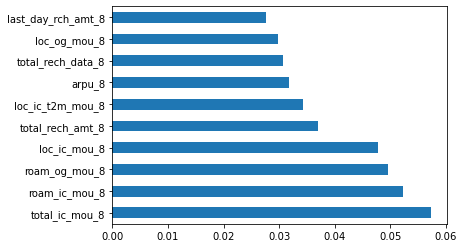

In [242]:
# Top 10 Important features
feat_importances = pd.Series(rfc.feature_importances_, index=X_test_st.columns)
feat_importances.nlargest(10).plot(kind='barh')


### Hyper Tuning Random Forest thorugh Grid Search

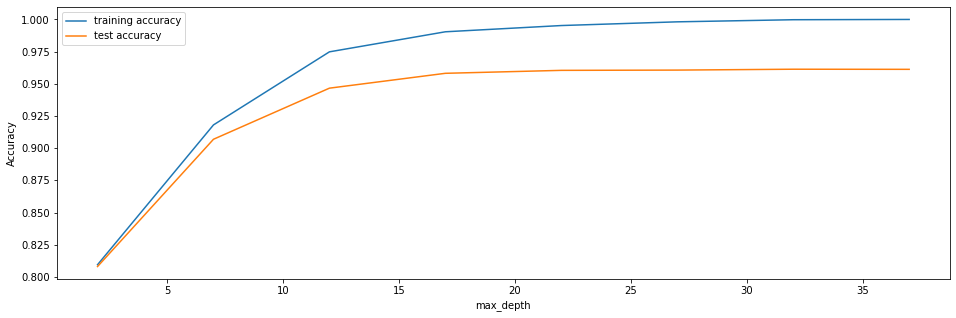

In [246]:
# Tuning max_depth
parameters = {'max_depth': range(2, 40, 5)}
tune_hyperparameter(parameters,X_train_st,y_train_smt)

# 18 value have peek convergens and can be used for grid veiw search.

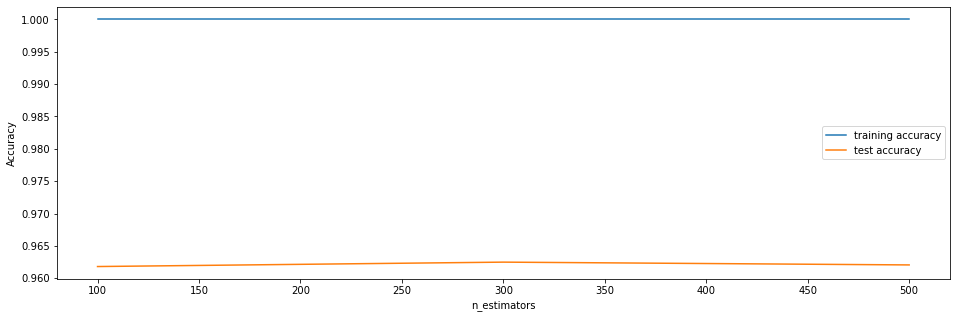

In [247]:
# Tuning n_estimators
parameters = {'n_estimators': range(100, 600, 200)}
tune_hyperparameter(parameters,X_train_st,y_train_smt)
# Training accuracy is flat, test accuracy stablizes after 300.

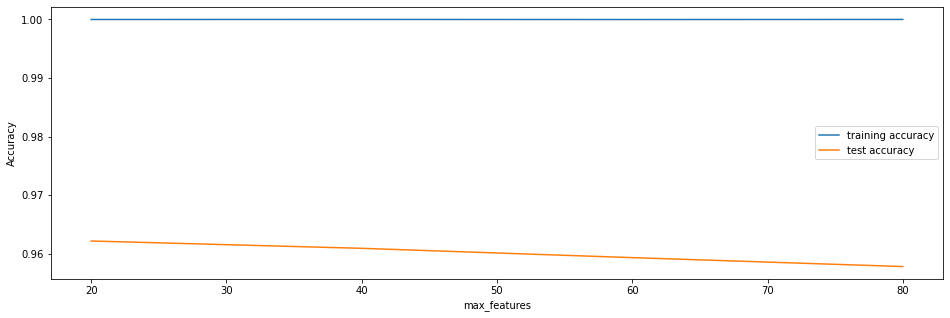

In [248]:
#  Tuning max_features
parameters = {'max_features': [20,40,60,80]}
tune_hyperparameter(parameters,X_train_st,y_train_smt,4)
# For training the feature seems to be stable... for test selecting 40.

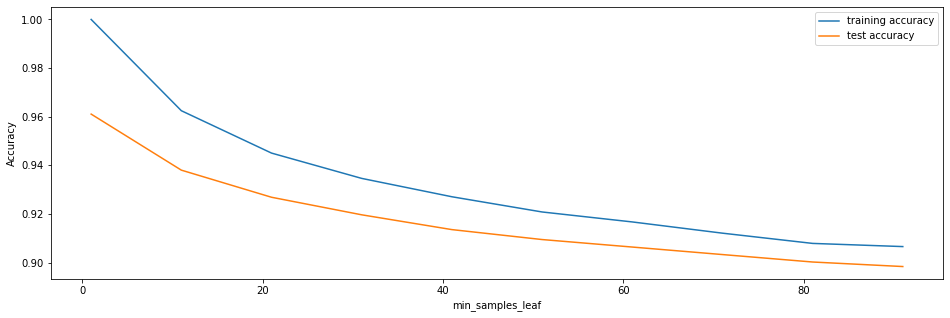

In [249]:
# Tuning min_samples_leaf
parameters = {'min_samples_leaf': range(1, 100, 10)}
tune_hyperparameter(parameters,X_train_st,y_train_smt)
# 10 to 20 seems good value post 20 the model seems to overfit

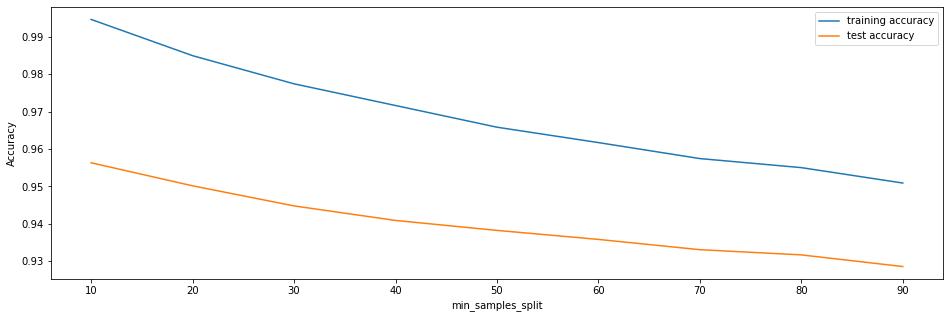

In [250]:
# Tuning min_samples_split
parameters = {'min_samples_split': range(10, 100, 10)}
tune_hyperparameter(parameters,X_train_st,y_train_smt)
#Range 10 to 40 seems to be optimal value, selecting 20

In [251]:
rfc = RandomForestClassifier(max_depth=18,
                             max_features=40,
                             min_samples_leaf=10,
                             min_samples_split=20,
                             n_estimators=300,
                             n_jobs = -1)


rfc.fit(X_train_st,y_train_smt)

# Making predictions
y_pred = rfc.predict(X_test_st)

cp = confusion_matrix(y_test,y_pred)
cp

array([[5181,  323],
       [ 129,  358]], dtype=int64)

In [252]:
# Evaluating model 
accuracy = round(accuracy_score(y_test,y_pred),2)
recall = round(recall_score(y_test,y_pred),2)
precision = round(precision_score(y_test,y_pred),2)
auc = round(roc_auc_score(y_test,y_pred),2)
f1 = round(f1_score(y_test,y_pred),2)

data = [[accuracy,recall,precision,auc,f1]] 
df = pd.DataFrame(data, columns = ['Accuracy','Precision','Recall','AUC','F1'])
df.head()

,Accuracy,Precision,Recall,AUC,F1
0,0.92,0.74,0.53,0.84,0.61


In [254]:
# Viewing most important features
feat_importances = pd.DataFrame(rfc.feature_importances_, index=X_test_st.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
print(feat_importances.shape)
feat_importances.head(10)

(136, 1)


,Importance
total_ic_mou_8,0.117865
loc_ic_mou_8,0.109097
roam_og_mou_8,0.086524
roam_ic_mou_8,0.066178
loc_ic_t2m_mou_8,0.064071
total_rech_data_8,0.052406
total_rech_amt_8,0.052161
av_rech_amt_data_8,0.030500
last_day_rch_amt_8,0.025835
arpu_8,0.023683


### Summary
#### Random Forest algorithm seems to be better after analysing through with or without PCA with 92% Accuracy, 82% AUC and less diference between Precision and Recall.
#### Incoming and Outgoing calls for 8th month are strong indicator for customer churn.
#### Average Revenue Per user is also important feature to predict customer churn.
#### Local in coming call duration is also important feature to predict customer churn.
#### Total Recharge for call and data strongly predicts customer churn.
#### Last day recharge amount also stronglt predicts customer churn.
#### During EDA it was alalysed that areas where 2G/3G services are not good storongly related to customer churn.
#### Customers with 2-5 years of tenure are more likely to churn. 